In [783]:
# manejo bbdd
import pandas as pd
import numpy as np
import datetime

#gráficas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#estadística
import math
from scipy.stats import norm
from scipy import stats #para box-cox entre otros
from scipy.stats import skew

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error,r2_score

In [784]:
import warnings
warnings.filterwarnings("ignore")

source: https://www.kaggle.com/datasets/jessemostipak/broadway-weekly-grosses?select=grosses.csv

In [785]:
df_cpi = pd.read_csv("Data/cpi.csv")
df_grosses = pd.read_csv("Data/grosses.csv")
df_pre_1985_starts = pd.read_csv("Data/pre_1985_starts.csv")
df_synopses = pd.read_csv("Data/synopses.csv")

In [786]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year_month  423 non-null    object 
 1   cpi         423 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [787]:
df_grosses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           47524 non-null  object 
 1   week_number           47524 non-null  int64  
 2   weekly_gross_overall  47524 non-null  float64
 3   show                  47524 non-null  object 
 4   theatre               47524 non-null  object 
 5   weekly_gross          47524 non-null  float64
 6   potential_gross       34911 non-null  float64
 7   avg_ticket_price      47524 non-null  float64
 8   top_ticket_price      36167 non-null  float64
 9   seats_sold            47524 non-null  int64  
 10  seats_in_theatre      47524 non-null  int64  
 11  pct_capacity          47524 non-null  float64
 12  performances          47524 non-null  int64  
 13  previews              47524 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 5.1+ MB


In [788]:
df_pre_1985_starts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   show        19 non-null     object
 1   start_date  19 non-null     object
dtypes: object(2)
memory usage: 436.0+ bytes


In [789]:
df_synopses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   show      1122 non-null   object
 1   synopsis  945 non-null    object
dtypes: object(2)
memory usage: 17.7+ KB


In [790]:
df_grosses.sample(3)

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
16577,2000-02-13,37,9612696.0,Jekyll & Hyde,Plymouth Theatre,359846.0,550486.0,54.73,80.0,6575,1064,0.7724,8,0
2209,1987-07-26,8,4389338.0,A Chorus Line,Sam S. Shubert Theatre,224869.0,NaN,28.88,NaN,7785,1472,0.6611,8,0
8698,1994-01-09,32,6291796.0,Blood Brothers,Music Box Theatre,218402.0,NaN,47.30,NaN,4617,992,0.5818,8,0


we will stick to the grosses one, as it is big enough to do the analysis!

### METADATA

- week_ending: Date of the end of the weekly measurement period. Always a Sunday.
- week_number: Week number in the Broadway season. The season starts after the Tony Awards, held in early June. Some seasons have 53 weeks.
- weekly_gross_overall: Weekly box office gross for all shows
- show: Name of show. Some shows have the same name, but multiple runs.
- theatre: Name of theatre
- weekly_gross: Weekly box office gross for individual show
- potential_gross: Weekly box office gross if all seats are sold at full price. Shows can exceed their potential gross by selling premium  tickets and/or standing room tickets.
- avg_ticket_price: Average price of tickets sold
- top_ticket_price: Highest price of tickets sold
- seats_sold: Total seats sold for all performances and previews
- seats_in_theatre: Theatre seat capacity
- pct_capacity: Percent of theatre capacity sold. Shows can exceed 100% capacity by selling standing room tickets.
- performances: Number of performances in the week
- previews: Number of preview performances in the week. Previews occur before a show's official open.

In [791]:
df_grosses.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,47524.000000,4.752400e+04,4.752400e+04,3.491100e+04,47524.000000,36167.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524.000000
mean,27.372170,1.669303e+07,5.744868e+05,9.395982e+05,67.914736,189.681892,7893.449668,1237.793536,0.802753,7.237754,0.583663
std,15.310139,9.520198e+06,4.433470e+05,4.193233e+05,38.589416,112.304515,3186.019908,358.357398,0.176418,2.229733,1.926202
min,1.000000,2.474396e+06,0.000000e+00,7.754000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,9.093031e+06,2.622292e+05,6.295230e+05,43.370000,85.000000,5442.000000,1021.000000,0.691400,8.000000,0.000000
50%,28.000000,1.506067e+07,4.700645e+05,9.031500e+05,60.235000,200.000000,7736.000000,1181.000000,0.833000,8.000000,0.000000
75%,41.000000,2.289759e+07,7.584381e+05,1.190502e+06,84.652500,250.000000,10187.000000,1509.000000,0.953800,8.000000,0.000000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1969.000000,1.553600,17.000000,16.000000


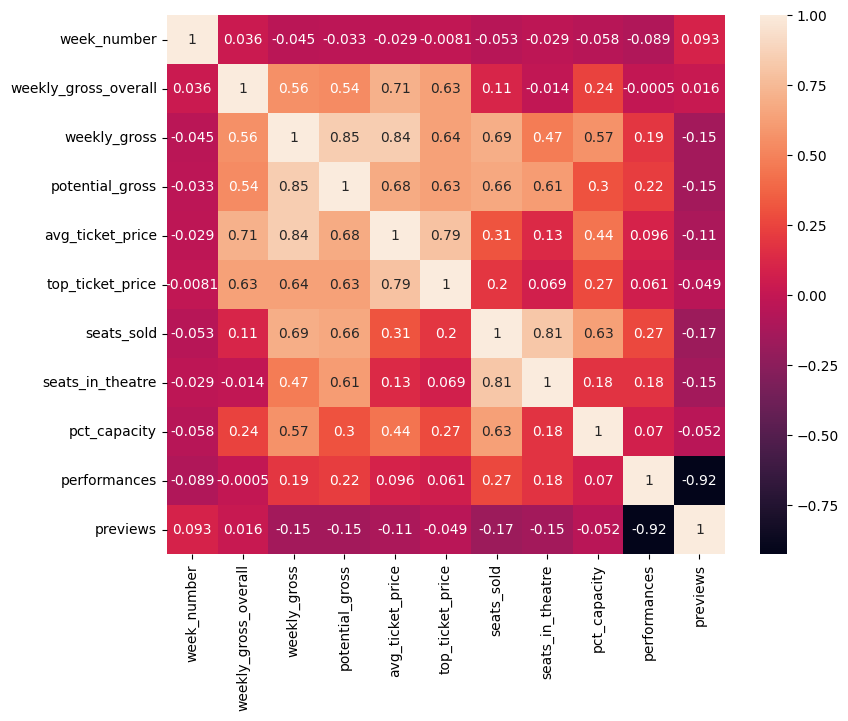

In [792]:
data_corr =df_grosses.select_dtypes(np.number)
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#at a first glance we can see there is a strong correlation between performances and previews!

In [793]:
print(df_grosses.previews.value_counts())
print(df_grosses.performances.value_counts())

previews
0     42998
8      1962
7       811
3       465
4       407
5       242
6       240
2       235
1       158
9         3
16        1
10        1
11        1
Name: count, dtype: int64
performances
8     39886
0      3556
7      1554
6       598
5       565
9       436
1       334
4       302
10       97
2        87
11       51
3        35
12       11
15        5
16        3
13        2
14        1
17        1
Name: count, dtype: int64


## Time Series Analysis

In [794]:
import datetime

In [795]:
df_grosses.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


variables que usaremos: tiempo y weekly gross.
Subanálisis de una obra específica? o de un teatro específico?

In [796]:
df_grosses.drop_duplicates() #no duplicates

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.00,42nd Street,St. James Theatre,282368.00,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.00,A Chorus Line,Sam S. Shubert Theatre,222584.00,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.00,Aren't We All?,Brooks Atkinson Theatre,249272.00,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.00,Arms and the Man,Circle in the Square Theatre,95688.00,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.00,As Is,Lyceum Theatre,61059.00,NaN,20.78,NaN,2938,684,0.5369,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47519,2020-03-01,40,26109896.25,The Phantom of the Opera,Majestic Theatre,639215.93,1358986.0,72.18,213.0,8856,1605,0.6897,8,0
47520,2020-03-01,40,26109896.25,Tina: The Tina Turner Musical,Lunt-Fontanne Theatre,1320766.00,1566688.0,132.02,297.0,10004,1478,0.8461,8,0
47521,2020-03-01,40,26109896.25,To Kill A Mockingbird,Sam S. Shubert Theatre,1132278.54,1549625.0,115.41,423.0,9811,1435,0.9767,7,0
47522,2020-03-01,40,26109896.25,West Side Story,Broadway Theatre,1598947.32,1722464.0,114.87,373.0,13920,1740,1.0000,8,0


In [797]:
time_series=df_grosses

In [798]:
time_series.sample()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
5456,1990-08-26,12,4874620.0,A Few Good Men,Music Box Theatre,121039.0,NaN,21.97,NaN,5509,997,0.6907,8,0


In [799]:
#creamos el año y el mes
time_series['week_ending2'] = pd.to_datetime(time_series.week_ending)

In [800]:
time_series.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews,week_ending2
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0,1985-06-09
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0,1985-06-09
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0,1985-06-09
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0,1985-06-09
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0,1985-06-09


In [801]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   week_ending           47524 non-null  object        
 1   week_number           47524 non-null  int64         
 2   weekly_gross_overall  47524 non-null  float64       
 3   show                  47524 non-null  object        
 4   theatre               47524 non-null  object        
 5   weekly_gross          47524 non-null  float64       
 6   potential_gross       34911 non-null  float64       
 7   avg_ticket_price      47524 non-null  float64       
 8   top_ticket_price      36167 non-null  float64       
 9   seats_sold            47524 non-null  int64         
 10  seats_in_theatre      47524 non-null  int64         
 11  pct_capacity          47524 non-null  float64       
 12  performances          47524 non-null  int64         
 13  previews        

In [802]:
time_series.week_ending2.min()

Timestamp('1985-06-09 00:00:00')

In [803]:
time_series.sort_values('week_ending2', inplace = True) #por norma no escrita se ordena por fecha
time_series.reset_index(drop=True, inplace = True)
time_series.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews,week_ending2
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0,1985-06-09
1,1985-06-09,1,3915937.0,The Tap Dance Kid,Minskoff Theatre,178556.0,NaN,26.78,NaN,6667,1621,0.5141,8,0,1985-06-09
2,1985-06-09,1,3915937.0,The Odd Couple,Broadhurst Theatre,91056.0,NaN,24.17,NaN,3768,1181,0.3988,0,8,1985-06-09
3,1985-06-09,1,3915937.0,The King and I,Broadway Theatre,407169.0,NaN,40.84,NaN,9969,1765,0.7060,8,0,1985-06-09
4,1985-06-09,1,3915937.0,Sunday in the Park with George,Booth Theatre,153364.0,NaN,31.43,NaN,4880,771,0.7912,8,0,1985-06-09


In [804]:
time_series.shape #ok

(47524, 15)

In [805]:
#coger el código de time series del otro pc (jupyter)

### Regresion Lineal

In [806]:
df_grosses.drop(columns=['week_ending'], inplace=True) #now we have the timeseries variable we don´t need the raw one anymore

In [807]:
df_grosses.sample()

,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews,week_ending2
15085,36,10105010.0,Annie Get Your Gun,Marquis Theatre,454128.0,790214.0,43.14,75.0,10527,1595,0.825,0,8,1999-02-07


#### Analysis of Categorical Variables

In [808]:
df_grosses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   week_number           47524 non-null  int64         
 1   weekly_gross_overall  47524 non-null  float64       
 2   show                  47524 non-null  object        
 3   theatre               47524 non-null  object        
 4   weekly_gross          47524 non-null  float64       
 5   potential_gross       34911 non-null  float64       
 6   avg_ticket_price      47524 non-null  float64       
 7   top_ticket_price      36167 non-null  float64       
 8   seats_sold            47524 non-null  int64         
 9   seats_in_theatre      47524 non-null  int64         
 10  pct_capacity          47524 non-null  float64       
 11  performances          47524 non-null  int64         
 12  previews              47524 non-null  int64         
 13  week_ending2    

In [809]:
df_grosses.show.value_counts()

show
The Phantom of the Opera                                      1677
Chicago                                                       1218
The Lion King                                                 1166
Les Miserables                                                1040
Cats                                                           874
                                                              ... 
Jerry Seinfeld: Live on Broadway                                 1
Bobbi Boland                                                     1
Il Divo - A Musical Affair: The Greatest Songs of Broadway       1
The Temptations & The Four Tops On Broadway                      1
Hangmen                                                          1
Name: count, Length: 1122, dtype: int64

In [810]:
df_grosses.theatre.value_counts()

theatre
Broadhurst Theatre                     1829
Minskoff Theatre                       1739
Majestic Theatre                       1677
Imperial Theatre                       1673
Ambassador Theatre                     1604
Gershwin Theatre                       1526
Eugene O'Neill Theatre                 1479
Lunt-Fontanne Theatre                  1472
St. James Theatre                      1460
Sam S. Shubert Theatre                 1314
Booth Theatre                          1301
Marquis Theatre                        1276
Vivian Beaumont Theater                1276
Richard Rodgers Theatre                1231
Helen Hayes Theatre                    1223
Broadway Theatre                       1216
Neil Simon Theatre                     1212
Ethel Barrymore Theatre                1170
Music Box Theatre                      1139
John Golden Theatre                    1130
Brooks Atkinson Theatre                1057
Winter Garden Theatre                  1055
Nederlander Theatre     

Feature Extraction

In [811]:
df_grosses['musical_type']='a'

In [812]:
def musical(show):
    legit=['Light in the Piazza', 'A Gentleman’s Guide to Love and Murder', 'The Bridges of Madison County', 'Grey Gardens', 'Jane Eyre', 'Doctor Zhivago', 'It Shoulda Been You', 'A Tale of Two Cities', 'The Woman in White', 'Mary Poppins', 'Little Women', 'Dracula', 'Amour', 'The Visit', 'A Class Act', 'White Christmas', 'Nice Work if You Can Get It', 'Chaplin', 'An American in Paris', 'LoveMusik', 'The People in the Picture, The Scottsboro Boys', 'The Story of My Life','A Catered Affair', 'A Year with Frog and Toad', 'By Jeeves', 'Chitty Chitty Bang Bang', 'James Joyce’s The Dead', 'Allegiance', 'Amazing Grace', 'The Green Bird', 'Lestat', 'Anastasia', 'Amelie', 'Holiday Inn', 'War Paint', 'Flying Over Sunset']
    mixed=['The Producers', 'The Book of Mormon', 'Thoroughly Modern Millie', 'Avenue Q', 'Newsies', 'The 25th Annual Putnam County Spelling Bee', 'The Drowsy Chaperone', 'The Color Purple', 'Curtains', 'Shrek', 'Catch Me If You Can', 'The Full Monty', 'Caroline or Change', 'Dirty Rotten Scoundrels', 'Legally Blonde', 'Wicked', 'Matilda', 'Hairspray', 'Young Frankenstein', 'Big Fish', 'The Addams Family', 'Fun Home', 'Seussical', 'Ghost', 'Something Rotten', 'Spamalot', 'Sweet Smell of Success', 'The Wild Party', 'Sister Act', 'A Christmas Story', 'Billy Elliot', 'The Little Mermaid', 'Aladdin', 'The Pirate Queen', 'Violet', 'Xanadu', 'Bullets Over Broadway', 'Dear Evan Hansen', '9 to 5', 'Cry-Baby', 'Charlie and the Chocolate Factory', 'Scandalous', 'Women on the Verge of a Nervous Breakdown', 'Rocky', 'Elf', 'First Date', 'Urban Cowboy', '[title of show]', 'Urinetown', '13', 'Finding Neverland', 'If/Then', 'School of Rock', 'Honeymoon in Vegas', 'The Adventures of Tom Sawyer', 'Charlie and the Chocolate Factory', 'Paradise Square', 'Mr. Saturday Night', 'A Strange Loop', 'Kimberly Akimbo']
    pop_rock=['Spring Awakening', 'Hamilton', 'Next to Normal', 'Once', 'Bloody', 'Bloody Andrew Jackson', 'Brooklyn', 'Aida', 'Bring it On', 'Kinky Boots', 'Hedwig and the Angry Inch', 'In the Heights', 'Wonderland', 'The Last Ship', 'Spider-Man: Turn off the Dark', 'Lysistrata Jones', 'Thou Shalt Not', 'Leap of Faith', 'The Wedding Singer', 'Tarzan', 'High Fidelity', 'Bonnie and Clyde', 'Dogfight', 'Passing Strange', 'Hands on a Hardbody', 'Taboo', 'Glory Days', 'Waitress', 'American Psycho', 'Bombay Dreams', 'Natasha', 'Pierre & The Great Comet of 1812','School of Rock', 'Hadestown', 'King Kong', 'Diana: The Musical', 'Almost Famous', 'Be More Chill', 'The Lightning Thief', 'Six', 'Jersey Boys', 'All Shook Up', 'American Idiot', 'Beautiful: The Carol King Musical', 'Mamma Mia!', 'Million Dollar Quartet', 'Motown', 'Rock of Ages', 'Holler If Ya Hear Me', 'Priscilla – Queen of the Desert', 'Good Vibrations', 'A Night with Janis Joplin', 'Baby It’s You!', 'Ring of Fire', 'The Boy from Oz', 'Soul Doctor', 'Lennon', 'Rain', 'Hot Feet', 'Movin’ Out', 'On Your Feet!', 'The Look of Love', 'The Times They Are a-Changin’', 'Everyday Rapture', 'Disaster!', 'Escape to Margarita Ville', 'Summer: The Donna Summer Musical', 'Head Over Heels', 'Ain’t Too Proud', 'Moulin Rouge', 'The Cher Show', 'Jagged Little Pill', 'MJ: The Musical', '&Juliet']


    if show in legit:
        return "legit"
    elif show in mixed:
        return "mixed"
    elif show in pop_rock:
        return "pop_rock"
    else:
        return "other"

In [813]:
df_grosses['musical_type'] = df_grosses['show'].apply(lambda x: musical(x))

In [814]:
df_grosses.musical_type.value_counts()

musical_type
other       37413
mixed        4993
pop_rock     4184
legit         934
Name: count, dtype: int64

Chi-squared

In [815]:
data_crosstab = pd.crosstab(df_grosses['musical_type'], df_grosses['theatre'], margins = False)
data_crosstab

theatre,46th Street Theatre,Al Hirschfeld Theatre,Ambassador Theatre,American Airlines Theatre,August Wilson Theatre,Belasco Theatre,Bernard B. Jacobs Theatre,Biltmore Theatre,Booth Theatre,Broadhurst Theatre,...,Royale Theatre,Sam S. Shubert Theatre,Samuel J. Friedman Theatre,St. James Theatre,Stephen Sondheim Theatre,Studio 54,Virginia Theatre,Vivian Beaumont Theater,Walter Kerr Theatre,Winter Garden Theatre
musical_type,,,,,,,,,,,,,,,,,,,,,
legit,0,12,17,0,0,0,0,0,3,106,...,0,0,0,0,0,0,24,0,61,0
mixed,0,88,0,20,0,13,76,0,0,12,...,0,204,0,342,0,0,14,0,0,27
other,205,277,1587,734,137,478,363,190,1203,954,...,635,1110,396,1055,426,787,623,1276,917,1028
pop_rock,0,358,0,12,588,101,149,0,95,757,...,0,0,0,63,0,0,0,0,59,0


In [816]:
from scipy.stats import chi2_contingency

chi2_contingency(data_crosstab, correction=False)

Chi2ContingencyResult(statistic=34154.027547794445, pvalue=0.0, dof=171, expected_freq=array([[4.02891171e+00, 1.44451225e+01, 3.15237775e+01, 1.50543725e+01,
        1.42485902e+01, 1.16347109e+01, 1.15560980e+01, 3.73411329e+00,
        2.55688494e+01, 3.59457537e+01, 2.38983251e+01, 2.07734618e+01,
        2.06751957e+01, 2.16185506e-01, 1.42485902e+01, 6.23007323e+00,
        4.97226664e+00, 2.29942766e+01, 2.90671240e+01, 6.44625873e+00,
        3.14451645e+00, 1.12809528e+01, 2.99908257e+01, 1.51329854e+00,
        2.40358977e+01, 2.96763740e+00, 2.86937127e+00, 2.47630671e+00,
        3.28798502e+01, 2.55491962e-01, 2.22081475e+01, 1.27745981e+01,
        2.89295514e+01, 1.65283646e+01, 4.20579076e+00, 3.29584631e+01,
        1.06127430e+00, 2.50775187e+01, 1.13595657e+01, 3.41769632e+01,
        2.23850265e+01, 2.07341554e+01, 2.38197121e+01, 1.28728642e+01,
        2.00266392e+01, 1.29318239e+01, 2.41931235e+01, 1.27745981e+00,
        1.24797997e+01, 2.58243414e+01, 7.7826782

In [817]:
data_crosstab = pd.crosstab(df_grosses['show'], df_grosses['theatre'], margins = False)
data_crosstab

theatre,46th Street Theatre,Al Hirschfeld Theatre,Ambassador Theatre,American Airlines Theatre,August Wilson Theatre,Belasco Theatre,Bernard B. Jacobs Theatre,Biltmore Theatre,Booth Theatre,Broadhurst Theatre,...,Royale Theatre,Sam S. Shubert Theatre,Samuel J. Friedman Theatre,St. James Theatre,Stephen Sondheim Theatre,Studio 54,Virginia Theatre,Vivian Beaumont Theater,Walter Kerr Theatre,Winter Garden Theatre
show,,,,,,,,,,,,,,,,,,,,,
"""Master Harold""...and the Boys",0,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0
"'night, Mother",0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
110 in the Shade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,0,0,0,0
13,0,0,0,0,0,0,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You're Welcome America,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"You're a Good Man, Charlie Brown",0,0,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Young Frankenstein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [818]:
chi2_contingency(data_crosstab, correction=False)

Chi2ContingencyResult(statistic=2478656.4779786835, pvalue=0.0, dof=63897, expected_freq=array([[0.0431361 , 0.1546587 , 0.33751368, ..., 0.26849592, 0.21820554,
        0.2219931 ],
       [0.05176332, 0.18559044, 0.40501641, ..., 0.3221951 , 0.26184665,
        0.26639172],
       [0.06901776, 0.24745392, 0.54002188, ..., 0.42959347, 0.34912886,
        0.35518896],
       ...,
       [0.28038465, 1.00528154, 2.1938389 , ..., 1.74522347, 1.418336  ,
        1.44295514],
       [0.03450888, 0.12372696, 0.27001094, ..., 0.21479673, 0.17456443,
        0.17759448],
       [0.06470415, 0.23198805, 0.50627052, ..., 0.40274388, 0.32730831,
        0.33298965]]))

Analysis of Numerical Variables

In [819]:
df_grosses.columns

Index(['week_number', 'weekly_gross_overall', 'show', 'theatre',
       'weekly_gross', 'potential_gross', 'avg_ticket_price',
       'top_ticket_price', 'seats_sold', 'seats_in_theatre', 'pct_capacity',
       'performances', 'previews', 'week_ending2', 'musical_type'],
      dtype='object')

In [820]:
df_grosses.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews,week_ending2
count,47524.000000,4.752400e+04,4.752400e+04,3.491100e+04,47524.000000,36167.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524
mean,27.372170,1.669303e+07,5.744868e+05,9.395982e+05,67.914736,189.681892,7893.449668,1237.793536,0.802753,7.237754,0.583663,2004-05-22 13:11:36.002020096
min,1.000000,2.474396e+06,0.000000e+00,7.754000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1985-06-09 00:00:00
25%,14.000000,9.093031e+06,2.622292e+05,6.295230e+05,43.370000,85.000000,5442.000000,1021.000000,0.691400,8.000000,0.000000,1996-10-20 00:00:00
50%,28.000000,1.506067e+07,4.700645e+05,9.031500e+05,60.235000,200.000000,7736.000000,1181.000000,0.833000,8.000000,0.000000,2005-01-02 00:00:00
75%,41.000000,2.289759e+07,7.584381e+05,1.190502e+06,84.652500,250.000000,10187.000000,1509.000000,0.953800,8.000000,0.000000,2012-09-30 00:00:00
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1969.000000,1.553600,17.000000,16.000000,2020-03-01 00:00:00
std,15.310139,9.520198e+06,4.433470e+05,4.193233e+05,38.589416,112.304515,3186.019908,358.357398,0.176418,2.229733,1.926202,NaN


In [821]:
df_grosses.week_number.value_counts()

week_number
47    1104
48    1095
46    1080
49    1078
50    1065
45    1045
26    1033
51    1032
27    1026
28    1021
25    1017
52    1016
29    1016
1     1014
30    1008
44    1004
2     1000
24     991
3      975
31     972
23     965
4      950
32     947
43     944
22     930
5      896
42     895
21     884
20     863
41     856
40     853
33     853
6      850
7      845
39     841
38     840
8      835
9      826
19     822
34     821
10     807
37     805
35     796
11     794
12     785
36     783
18     780
13     766
17     759
14     736
16     735
15     718
53     152
Name: count, dtype: int64

In [822]:
df_grosses.weekly_gross_overall.value_counts()

weekly_gross_overall
41151034.39    40
35186711.31    40
39865469.32    40
29706151.00    39
26084412.00    39
               ..
4615585.00     11
3888778.00     11
4264963.00     11
4695374.00     11
4822355.00     11
Name: count, Length: 1812, dtype: int64

In [823]:
df_grosses.weekly_gross.value_counts()

weekly_gross
0.0          125
10000.0       19
20000.0        9
35000.0        8
186990.0       3
            ... 
417747.0       1
638972.0       1
197133.0       1
418748.0       1
1202089.5      1
Name: count, Length: 46414, dtype: int64

In [824]:
df_grosses.potential_gross.value_counts()

potential_gross
528739.0     483
1042163.0    300
604476.0     280
560680.0     251
1002310.0    240
            ... 
682740.0       1
749511.0       1
571350.0       1
1652776.0      1
215634.0       1
Name: count, Length: 5385, dtype: int64

In [825]:
df_grosses.avg_ticket_price.value_counts()

avg_ticket_price
0.00      125
8.33       19
52.23      18
41.11      18
47.80      17
         ... 
133.64      1
174.02      1
152.17      1
132.21      1
96.33       1
Name: count, Length: 12885, dtype: int64

In [826]:
df_grosses.top_ticket_price.value_counts()

top_ticket_price
75.00     2481
250.00    2335
200.00    1565
225.00    1499
240.00    1349
          ... 
126.25       1
600.00       1
136.25       1
4.00         1
747.00       1
Name: count, Length: 244, dtype: int64

In [827]:
df_grosses.seats_sold.value_counts()

seats_sold
13096    313
14472    257
8752     170
0        125
12976     97
        ... 
1212       1
1907       1
13623      1
1412       1
12863      1
Name: count, Length: 12300, dtype: int64

In [828]:
df_grosses.seats_in_theatre.value_counts()

seats_in_theatre
1080    926
1482    806
499     790
1498    621
1181    601
       ... 
1390      1
1343      1
1020      1
1215      1
1345      1
Name: count, Length: 706, dtype: int64

In [829]:
df_grosses.pct_capacity.value_counts() #it makes no sense to have more than 1 , as we can't have more than 100%? drop it?

pct_capacity
1.0000    968
1.0174    329
1.0263    165
0.0000    133
1.0002    105
         ... 
0.5006      1
1.0432      1
1.0391      1
1.0302      1
1.0348      1
Name: count, Length: 6873, dtype: int64

In [830]:
df_grosses.performances.value_counts()

performances
8     39886
0      3556
7      1554
6       598
5       565
9       436
1       334
4       302
10       97
2        87
11       51
3        35
12       11
15        5
16        3
13        2
14        1
17        1
Name: count, dtype: int64

In [831]:
df_grosses.previews.value_counts()

previews
0     42998
8      1962
7       811
3       465
4       407
5       242
6       240
2       235
1       158
9         3
16        1
10        1
11        1
Name: count, dtype: int64

In [832]:
regression=df_grosses #we make a copy of the database so that we keep the mother db ok

Let's make some graphs to see if there is linear relationship between the Xs and the Y

In [833]:
regression.columns

Index(['week_number', 'weekly_gross_overall', 'show', 'theatre',
       'weekly_gross', 'potential_gross', 'avg_ticket_price',
       'top_ticket_price', 'seats_sold', 'seats_in_theatre', 'pct_capacity',
       'performances', 'previews', 'week_ending2', 'musical_type'],
      dtype='object')

<Axes: xlabel='week_number', ylabel='weekly_gross'>

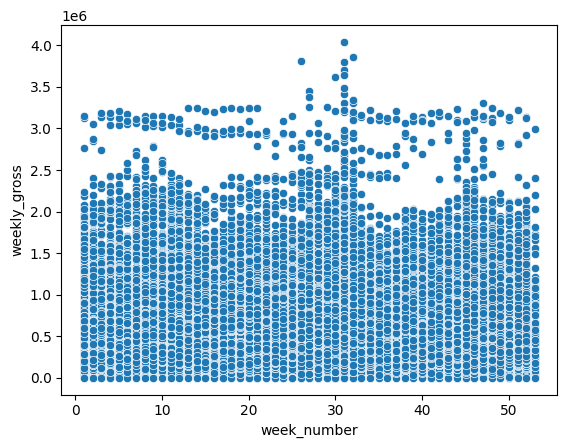

In [834]:
sns.scatterplot(x='week_number', y='weekly_gross', data=regression) #no linear relationship at all

<Axes: xlabel='weekly_gross_overall', ylabel='weekly_gross'>

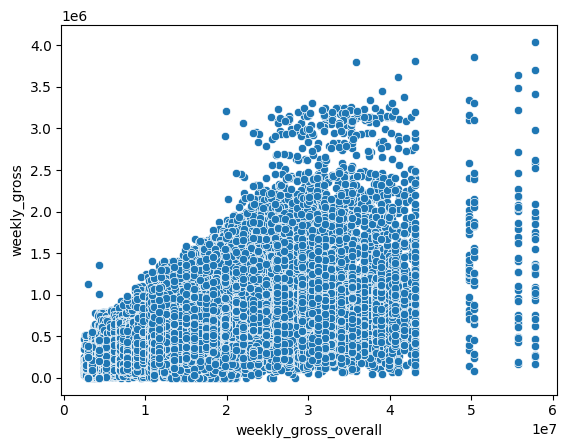

In [835]:
sns.scatterplot(x='weekly_gross_overall', y='weekly_gross', data=regression) #kind of linear?

<Axes: xlabel='potential_gross', ylabel='weekly_gross'>

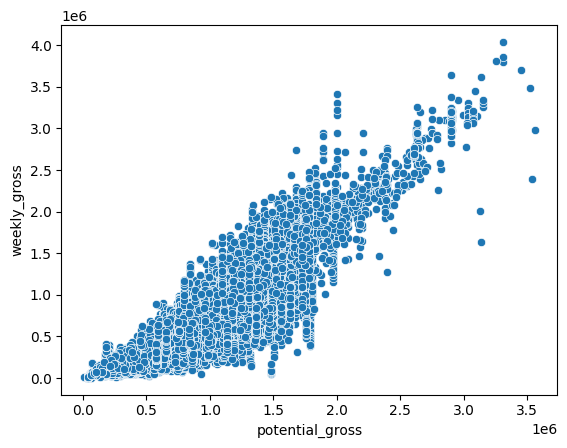

In [836]:
sns.scatterplot(x='potential_gross', y='weekly_gross', data=regression) #linear relationship!

<Axes: xlabel='avg_ticket_price', ylabel='weekly_gross'>

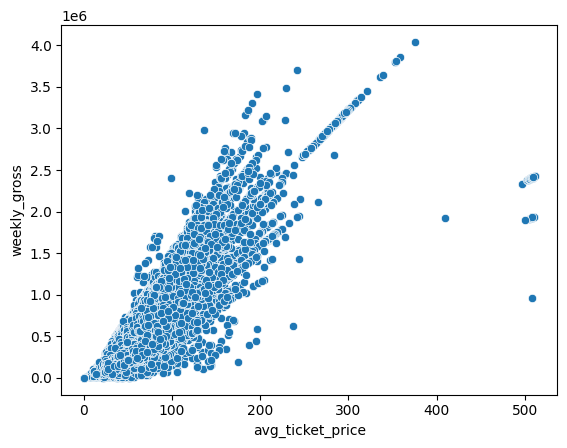

In [837]:
sns.scatterplot(x='avg_ticket_price', y='weekly_gross', data=regression) #linear relationship!

<Axes: xlabel='top_ticket_price', ylabel='weekly_gross'>

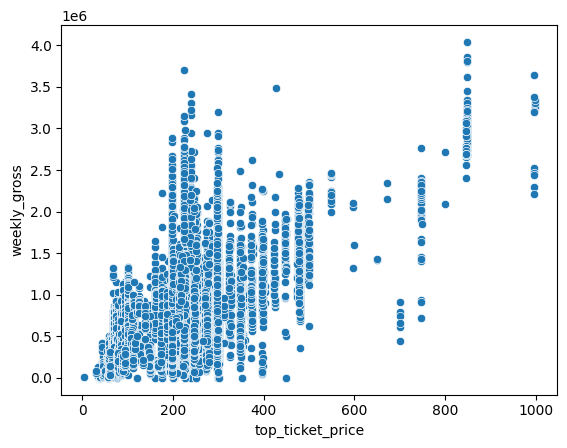

In [838]:
sns.scatterplot(x='top_ticket_price', y='weekly_gross', data=regression) #slightly linear?

<Axes: xlabel='seats_sold', ylabel='weekly_gross'>

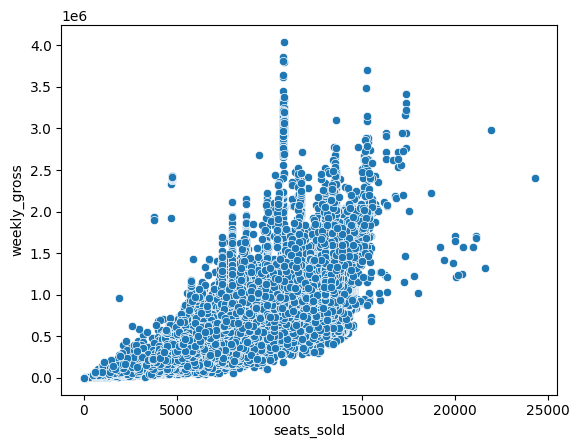

In [839]:
sns.scatterplot(x='seats_sold', y='weekly_gross', data=regression) #slightly linear?

<Axes: xlabel='seats_in_theatre', ylabel='weekly_gross'>

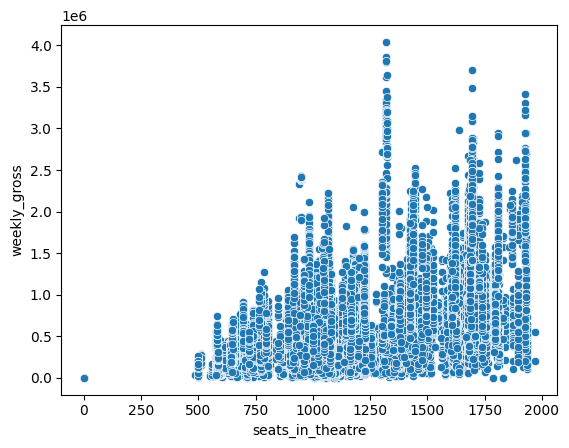

In [840]:
sns.scatterplot(x='seats_in_theatre', y='weekly_gross', data=regression) #not linear

<Axes: xlabel='performances', ylabel='weekly_gross'>

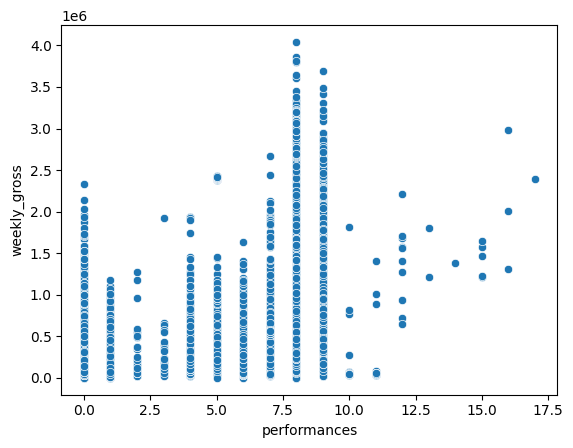

In [841]:
sns.scatterplot(x='performances', y='weekly_gross', data=regression) #not linear

<Axes: xlabel='previews', ylabel='weekly_gross'>

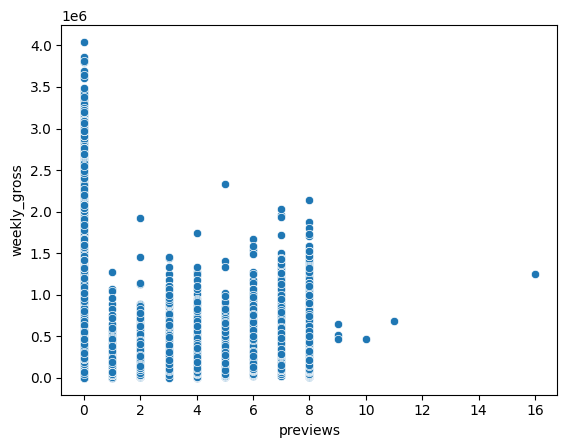

In [842]:
sns.scatterplot(x='previews', y='weekly_gross', data=regression) #not linear

In [843]:
regression.columns

Index(['week_number', 'weekly_gross_overall', 'show', 'theatre',
       'weekly_gross', 'potential_gross', 'avg_ticket_price',
       'top_ticket_price', 'seats_sold', 'seats_in_theatre', 'pct_capacity',
       'performances', 'previews', 'week_ending2', 'musical_type'],
      dtype='object')

In [844]:
regression.drop(columns=['pct_capacity', 'week_ending2'], inplace=True)

In [845]:
regression.shape

(47524, 13)

Let's do some transformations!

Let's see the shape of the histograms first :) then, if necessary, transform

In [846]:
def log_transform_clean_(x):
    x=np.log(x)
    if np.isfinite(x) and x>0:
        return x
    else:
        return np.NAN 

In [847]:
def sqrt_transform_clean_(x):
    if np.isfinite(x) and x>=0:
        return np.sqrt(x)
    else:
        return np.NAN # We are returning NaNs so that we can replace them later

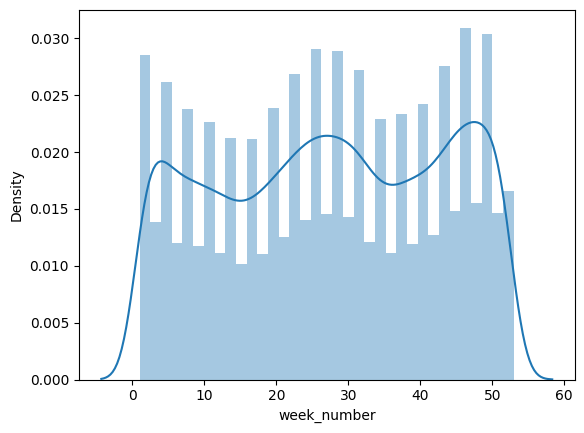

In [848]:
sns.distplot(regression.week_number) #kind of uniform...I would not transform
plt.show()

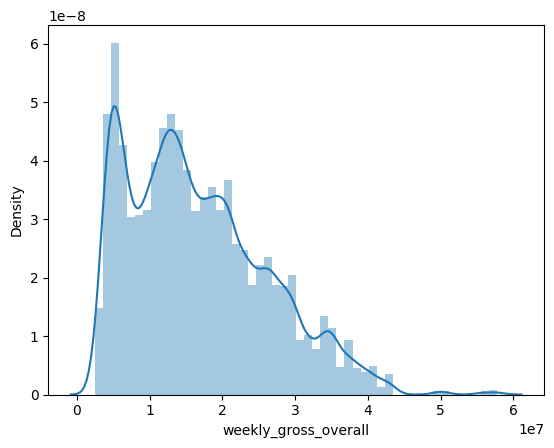

In [849]:
sns.distplot(regression.weekly_gross_overall)
plt.show()

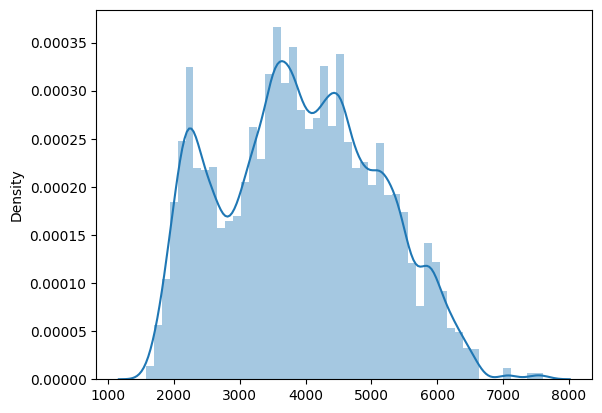

In [850]:
weekly_gross_overall_sqrt = list(map(sqrt_transform_clean_, regression.weekly_gross_overall))
sns.distplot(weekly_gross_overall_sqrt)
plt.show()

In [851]:
regression['weekly_gross_overall_sqrt']=weekly_gross_overall_sqrt
regression=regression.drop(['weekly_gross_overall'], axis=1) 

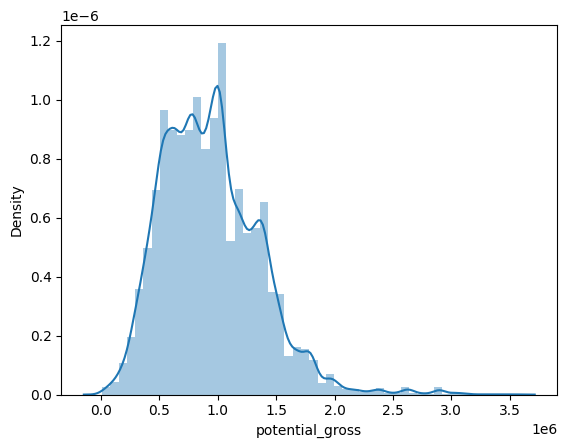

In [852]:
sns.distplot(regression.potential_gross) #kind of uniform...I would not transform
plt.show()

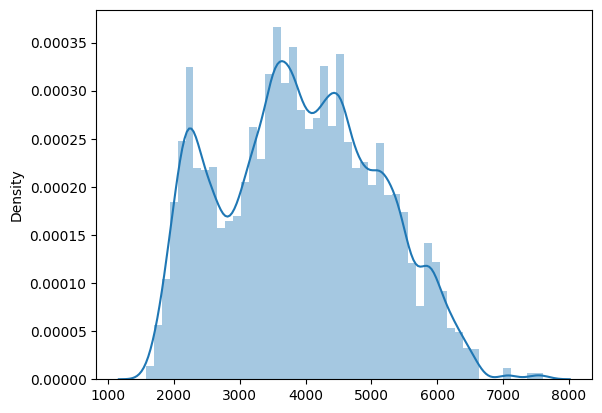

In [853]:
potential_gross_sqrt = list(map(sqrt_transform_clean_, regression.potential_gross))
sns.distplot(weekly_gross_overall_sqrt)
plt.show()

In [854]:
regression['potential_gross_sqrt']=potential_gross_sqrt
regression=regression.drop(['potential_gross'], axis=1) 

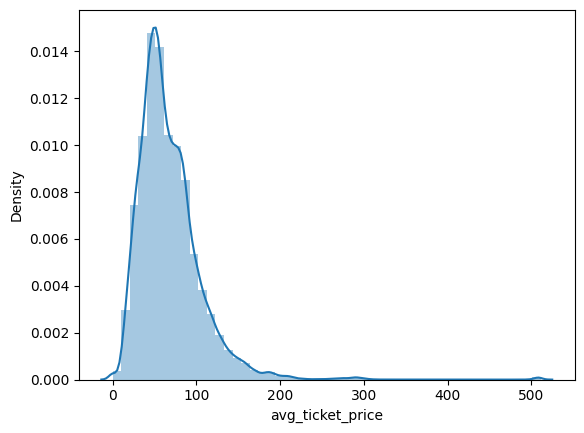

In [855]:
sns.distplot(regression.avg_ticket_price) 
plt.show()

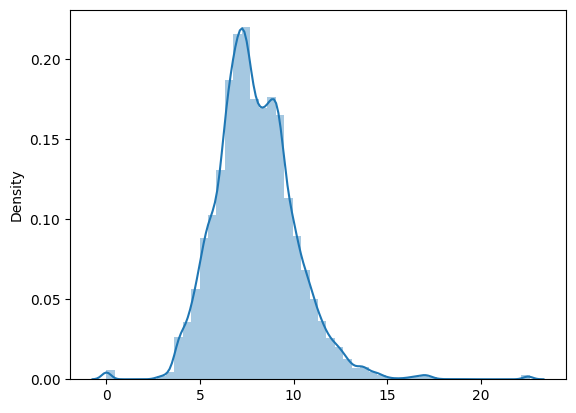

In [856]:
avg_ticket_price_sqrt = list(map(sqrt_transform_clean_, regression.avg_ticket_price))
sns.distplot(avg_ticket_price_sqrt)
plt.show()

In [857]:
regression['avg_ticket_price_sqrt']=avg_ticket_price_sqrt
regression=regression.drop(['avg_ticket_price'], axis=1) 

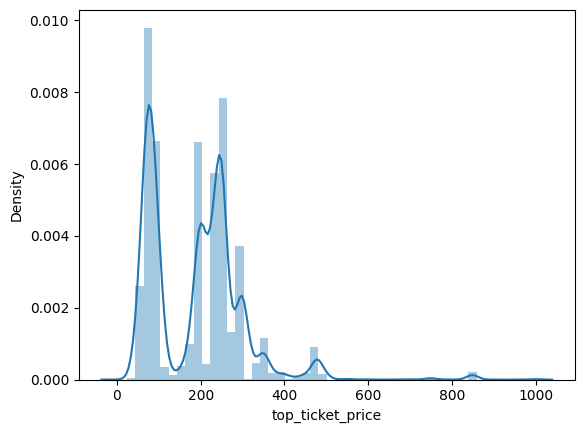

In [858]:
sns.distplot(regression.top_ticket_price)
plt.show()

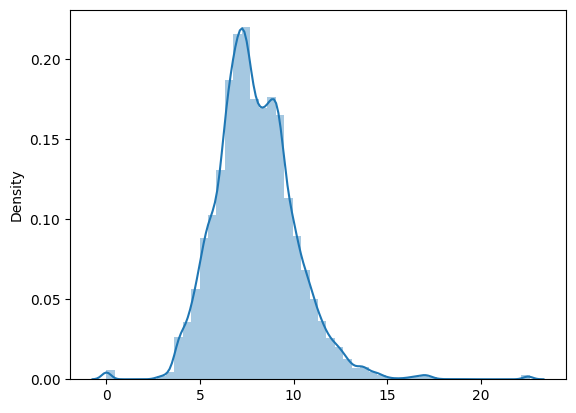

In [859]:
top_ticket_price_sqrt = list(map(sqrt_transform_clean_, regression.top_ticket_price))
sns.distplot(avg_ticket_price_sqrt)
plt.show()

In [860]:
regression['top_ticket_price_sqrt']=top_ticket_price_sqrt
regression=regression.drop(['top_ticket_price'], axis=1) 

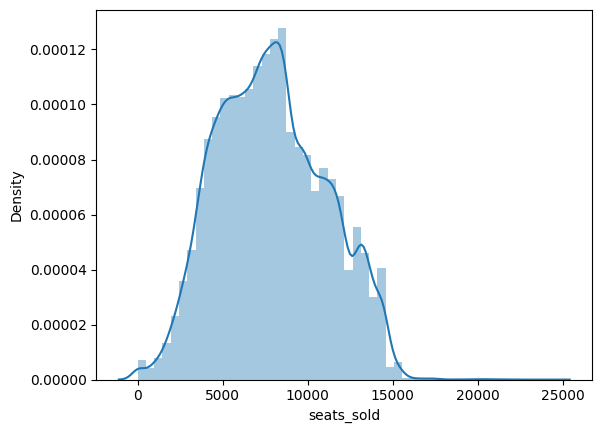

In [861]:
sns.distplot(regression.seats_sold) #I think there are some outliers so I wouldn't transform
plt.show()

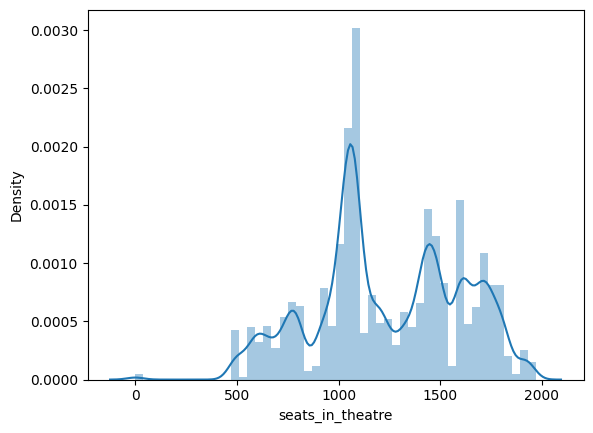

In [862]:
sns.distplot(regression.seats_in_theatre) #those 0s are not correct so I would change them
plt.show()

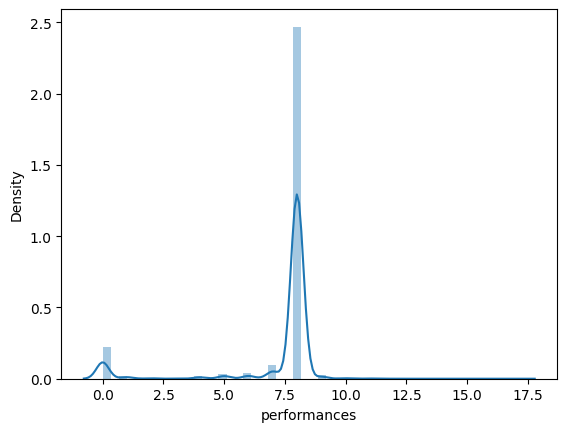

In [863]:
sns.distplot(regression.performances) #no need to transform
plt.show()

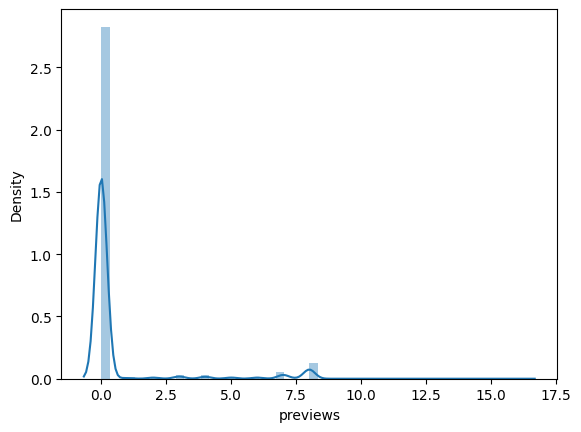

In [864]:
sns.distplot(regression.previews) 
plt.show()

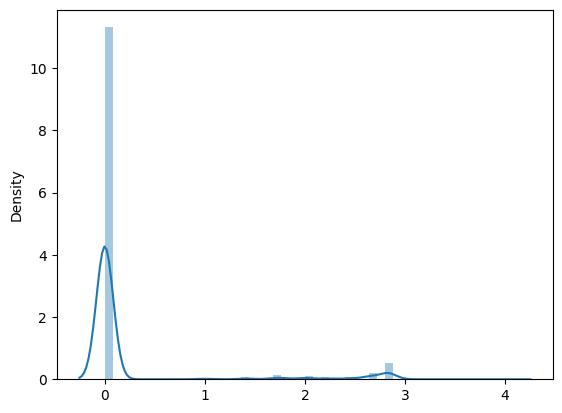

In [865]:
previews_sqrt = list(map(sqrt_transform_clean_, regression.previews))
sns.distplot(previews_sqrt)
plt.show() #when transforming this makes no sense..if we do it with log, there are lots of missing and some 0s may be right! wouldn't transform

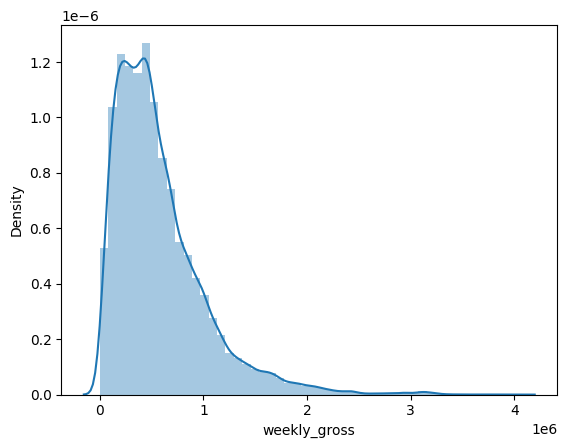

In [878]:
#and the Y variable:

sns.distplot(regression.weekly_gross)
plt.show()

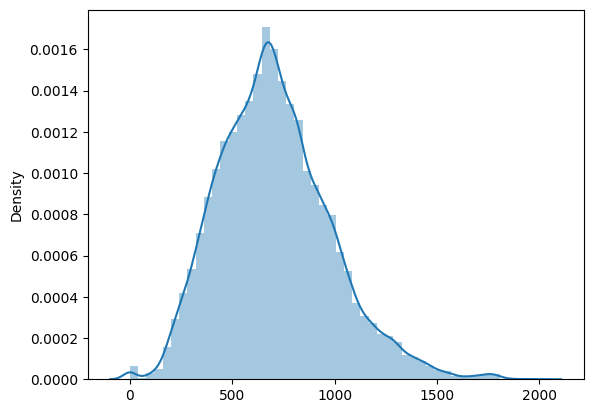

In [881]:
weekly_gross_sqrt = list(map(sqrt_transform_clean_, regression.weekly_gross))
sns.distplot(weekly_gross_sqrt)
plt.show()

In [882]:
regression['weekly_gross_sqrt']=weekly_gross_sqrt
regression=regression.drop(['weekly_gross'], axis=1) 

In [883]:
regression.columns

Index(['week_number', 'show', 'theatre', 'seats_sold', 'seats_in_theatre',
       'performances', 'previews', 'musical_type', 'weekly_gross_overall_sqrt',
       'potential_gross_sqrt', 'avg_ticket_price_sqrt',
       'top_ticket_price_sqrt', 'weekly_gross_sqrt'],
      dtype='object')

Check if there are rows with all 0 values. If everythin is 0 we can drop. Otherwise keep it as it can be for a reason!

In [867]:
zeros_check=regression.drop(columns=['musical_type', 'week_number'])

In [868]:
df = zeros_check.loc[(zeros_check!=0).any(axis=1)]

In [869]:
zeros_check.columns

Index(['show', 'theatre', 'weekly_gross', 'seats_sold', 'seats_in_theatre',
       'performances', 'previews', 'weekly_gross_overall_sqrt',
       'potential_gross_sqrt', 'avg_ticket_price_sqrt',
       'top_ticket_price_sqrt'],
      dtype='object')

In [870]:
df.shape #not a columns with all 0s!

(47524, 11)

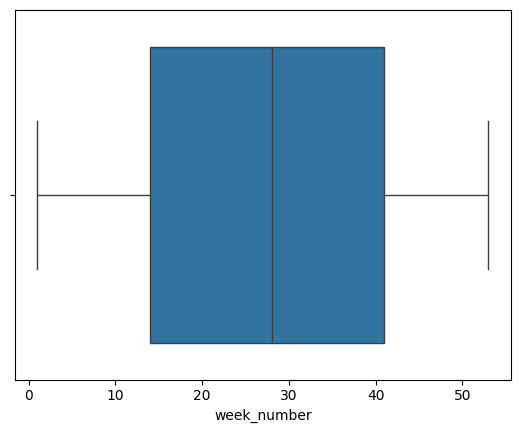

In [871]:
sns.boxplot(x=regression.week_number)
plt.show()

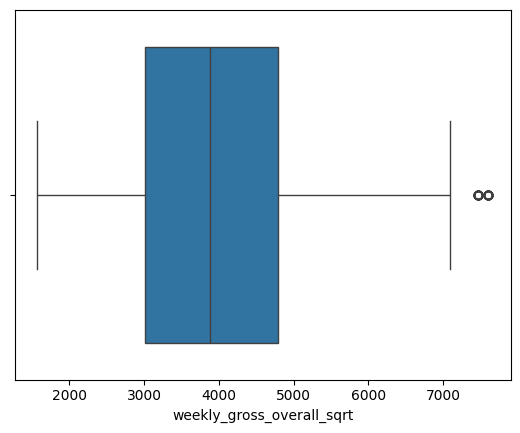

In [875]:
sns.boxplot(x=regression.weekly_gross_overall_sqrt)
plt.show()

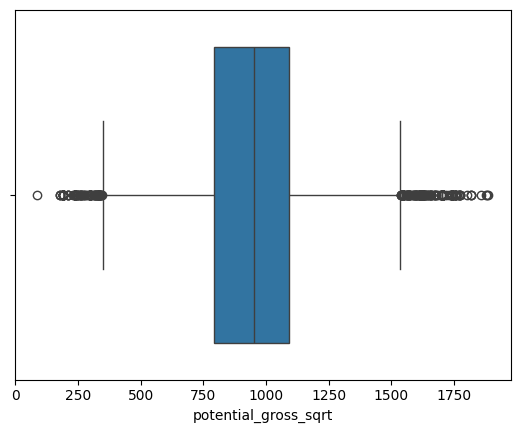

In [887]:
sns.boxplot(x=regression.potential_gross_sqrt)
plt.show()

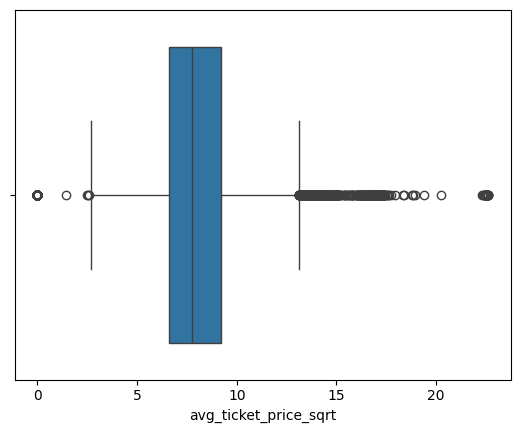

In [888]:
sns.boxplot(x=regression.avg_ticket_price_sqrt)
plt.show()

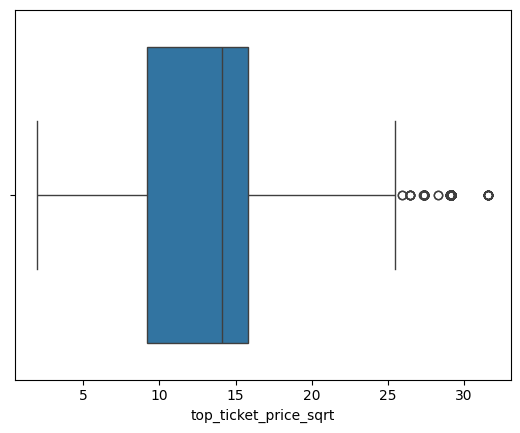

In [890]:
sns.boxplot(x=regression.top_ticket_price_sqrt)
plt.show()

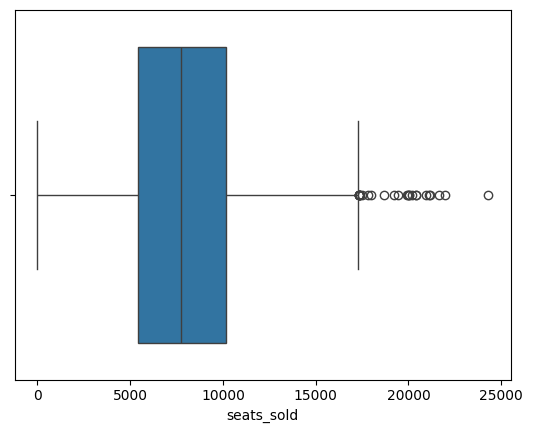

In [885]:
sns.boxplot(x=regression.seats_sold)
plt.show()

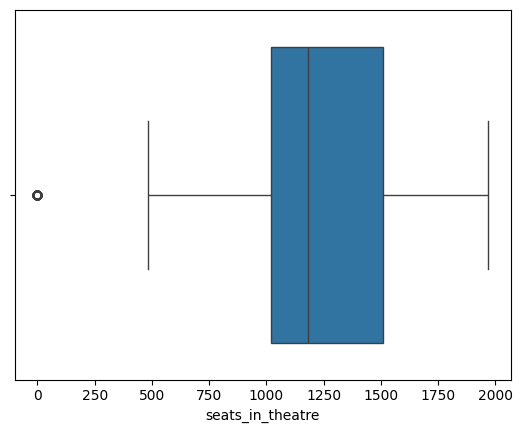

In [886]:
sns.boxplot(x=regression.seats_in_theatre)
plt.show()

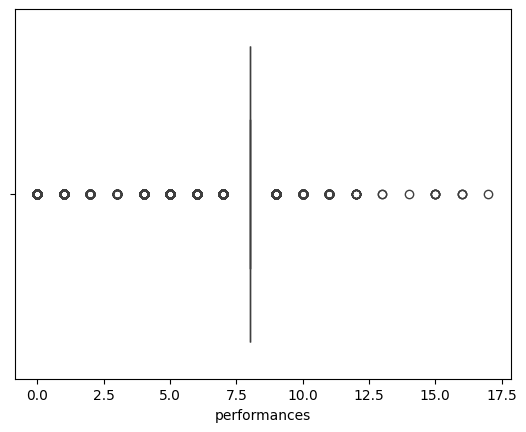

In [892]:
sns.boxplot(x=regression.performances)
plt.show()

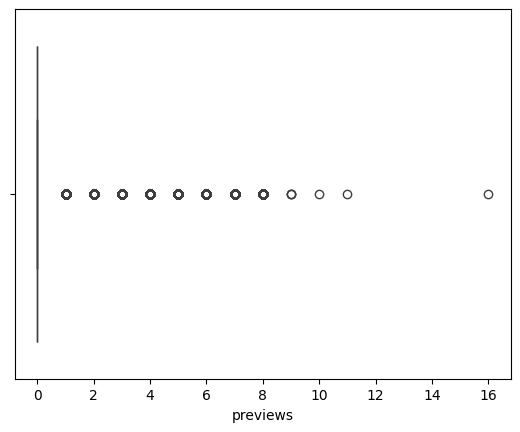

In [893]:
sns.boxplot(x=regression.previews)
plt.show()

In [884]:
regression.columns

Index(['week_number', 'show', 'theatre', 'seats_sold', 'seats_in_theatre',
       'performances', 'previews', 'musical_type', 'weekly_gross_overall_sqrt',
       'potential_gross_sqrt', 'avg_ticket_price_sqrt',
       'top_ticket_price_sqrt', 'weekly_gross_sqrt'],
      dtype='object')

Dealing with Outliers

In [ ]:
#we have positive skewness. Outliers in this variable are only on the right side of the distribution
iqr = np.percentile(numericals['cust_lftm_val_log'],75) - np.percentile(numericals['cust_lftm_val_log'],25)
upper_limit = np.percentile(numericals['cust_lftm_val_log'],75) + 1.5*iqr
print(upper_limit)